# Video

blah ...

second try

# Data Formats

Data was saved to a `dict` with each key being a `list` full of `namedtuples`. The `Data_ts` hold the data plus a time stamp since the start of the data.

- `imu`: accel, mag, gyros
- `camera`: image bytes
- `lidar`: array of (angle, range,) for each point

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from collections import namedtuple
import time
import pickle
import cv2

Data_ts = namedtuple('Data_ts', 'data timestamp')

In [4]:
data = pickle.load( open( "data.pickle", "rb" ) )

In [30]:
imgs = [np.frombuffer(x[0], dtype=np.uint8).reshape((480,640)) for x in data['camera']]
itime = [x[1] for x in data['camera']]

print('Images found: {}'.format(len(imgs)))

Images found: 1000


In [26]:
class VO(object):
    def featureDetection(self):
        thresh = dict(threshold=25, nonmaxSuppression=True);
        fast = cv2.FastFeatureDetector_create(**thresh)
        return fast
    
    def getK(self):
        return np.array([[7.188560000000e+02, 0, 6.071928000000e+02],
                          [0, 7.188560000000e+02, 1.852157000000e+02],
                          [0, 0, 1]])

    def getAbsoluteScale(self, f0, f1):
        x_pre, y_pre, z_pre = f0
        x    , y    , z     = f1
        scale = np.sqrt((x-x_pre)**2 + (y-y_pre)**2 + (z-z_pre)**2)
        return x, y, z, scale

    def featureTracking(self, img_1, img_2, p1):
        lk_params = dict(
            winSize  = (21,21),
            maxLevel = 3,
            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

        p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
        st = st.reshape(st.shape[0])
        ##find good one
        p1 = p1[st==1]
        p2 = p2[st==1]

        return p1,p2
    
    def run(self, images):
        #initialization
    #     ground_truth =getTruePose()

        img_1 = images[0]
        img_2 = images[0]

        if len(img_1) == 3:
            gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
            gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
        else:
            gray_1 = img_1
            gray_2 = img_2

        #find the detector
        detector = self.featureDetection()
        kp1      = detector.detect(img_1)
        p1       = np.array([kp.pt for kp in kp1],dtype='float32')
        p1, p2   = self.featureTracking(gray_1, gray_2, p1)

        #Camera parameters
        fc = 718.8560
        pp = (640/2, 480/2)
    #     K  = getK()

        E, mask = cv2.findEssentialMat(p2, p1, fc, pp, cv2.RANSAC,0.999,1.0);
        _, R, t, mask = cv2.recoverPose(E, p2, p1,focal=fc, pp = pp);

        #initialize some parameters
        MAX_FRAME     = 500
        MIN_NUM_FEAT  = 150

        preFeature = p2
        preImage   = gray_2

        R_f = R
        t_f = t

        maxError = 0
        ret_pos = []

        for numFrame in range(2, MAX_FRAME):

#             if numFrame % 20 == 0:
#                 print(numFrame)

            if (len(preFeature) < MIN_NUM_FEAT):
                feature   = detector.detect(preImage)
                preFeature = np.array([ele.pt for ele in feature],dtype='float32')
#                 print(">> features found: ", len(preFeature))
                if len(preFeature) < MIN_NUM_FEAT:
                    continue

            curImage_c = images[numFrame]

            if len(curImage_c) == 3:
                  curImage = cv2.cvtColor(currImage_c, cv2.COLOR_BGR2GRAY)
            else:
                  curImage = curImage_c

            kp1 = detector.detect(curImage);
            preFeature, curFeature = self.featureTracking(
                preImage, 
                curImage, 
                preFeature)
            E, mask = cv2.findEssentialMat(
                curFeature, 
                preFeature, 
                fc, 
                pp, 
                cv2.RANSAC,
                0.999,
                1.0);

    #         print(E)

            _, R, t, mask = cv2.recoverPose(
                E, 
                curFeature, 
                preFeature, 
                focal=fc, 
                pp = pp);

    #         truth_x, truth_y, truth_z, absolute_scale = getAbsoluteScale(
    #             ground_truth[numFrame-1], ground_truth[numFrame])

    #         if numFrame % 20 == 0:
    #             print('scale', absolute_scale)

            absolute_scale = 1.0

            if absolute_scale > 0.1:
                t_f = t_f + absolute_scale*R_f.dot(t)
                R_f = R.dot(R_f)
            else:
                print("crap ... bad scale:", absolute_scale)

            preImage = curImage
            preFeature = curFeature

    #         ret_pos.append((t_f[0], t_f[2],))
            ret_pos.append(t_f)

        return ret_pos

In [27]:
vo = VO()
pos = vo.run(imgs)

In [38]:
x = [float(x[0]) for x in pos]
y = [float(x[1]) for x in pos]
z = [float(x[2]) for x in pos]

Text(0.5, 1.0, 'Movement')

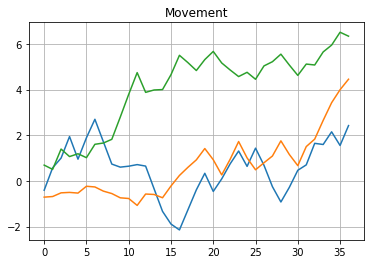

In [44]:
plt.figure()
for i in [x,y,z]:
    plt.plot(i)
plt.grid(True)
plt.title('Movement')